In [1]:
%matplotlib inline
import os
# os.environ['THEANO_FLAGS']='contexts=dev0->cuda0;dev1->cuda1'
os.environ['THEANO_FLAGS']='device=gpu1'
import time
import matplotlib
import lasagne
import theano
import theano.tensor as T
import pylab as P
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
from helpers.DiscreteLayer import DiscreteLayer
try:
    from lasagne.layers.dnn import Conv2DDNNLayer as conv
    from lasagne.layers.dnn import MaxPool2DDNNLayer as pool
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as conv
    from lasagne.layers import MaxPool2DLayer as pool

Using gpu device 1: Tesla K40c (CNMeM is enabled with initial size: 49.0% of memory, cuDNN 5005)


Using cuda_convnet (faster)


In [2]:
# Constants
NUM_EPOCHS = 1500
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "data/mnist_cluttered_60x60_6distortions.npz"

# Disc. Layer Settings
DISC = True
ADD_NOISE = True
QUANT = np.array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125], dtype='float32')
VARIANCE_DEVIDER = 16.0

# Test Specs
TEST_NAME = 'test_template'

# Additional Settings
lasagne.random.set_rng(np.random.RandomState(12345))  # Set random state so we can investigate results
np.random.seed(1234)
#theano.config.exception_verbosity = 'high'

In [3]:
def load_data():
    data = np.load(mnist_cluttered)
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
    
    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    # stack train and valid, we wont be using valid
    X_train = np.concatenate([X_train, X_valid], axis=0)
    y_train = np.concatenate([y_train, y_valid], axis=0)
        
    print "Train samples:", X_train.shape
    print "Test samples:", X_test.shape

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        y_train=y_train.astype('int32'),
        X_test=lasagne.utils.floatX(X_test),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data()

Train samples: (60000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


In [4]:
def build_model(input_width, input_height, output_dim,
                batch_size=BATCH_SIZE, withdisc=True):
    ini = lasagne.init.HeUniform()
    l_in = lasagne.layers.InputLayer(shape=(None, 1, input_width, input_height),)
    #l_in = lasagne.layers.DropoutLayer(l_in, p=0.1)

    # Localization network
    b = np.zeros((2, 3), dtype=theano.config.floatX)
    b[0, 0] = 1
    b[1, 1] = 1
    b = b.flatten()
    loc_l1 = pool(l_in, pool_size=(2, 2))
    loc_l2 = conv(
        loc_l1, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l3 = pool(loc_l2, pool_size=(2, 2))
    loc_l4 = conv(loc_l3, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l5 = lasagne.layers.DenseLayer(
        loc_l4, num_units=50, W=lasagne.init.HeUniform('relu'))
    loc_out = lasagne.layers.DenseLayer(
        loc_l5, num_units=6, b=b, W=lasagne.init.Constant(0.0), 
        nonlinearity=lasagne.nonlinearities.identity, name='param_regressor')
    
    if withdisc:
        sharedBins = theano.shared(None, name='sharedBins')
        l_dis = DiscreteLayer(loc_out, sharedBins=sharedBins, name='disclayer')
        print("Using Discret. Layer")
    else:
        l_dis = loc_out
        print("No Disc. Layer")
    
    # Transformer network
    l_trans1 = lasagne.layers.TransformerLayer(l_in, l_dis, downsample_factor=3.0)
    print "Transformer network output shape: ", l_trans1.output_shape
    
    # Classification network
    class_l1 = conv(
        l_trans1,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l2 = pool(class_l1, pool_size=(2, 2))
    class_l3 = conv(
        class_l2,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l4 = pool(class_l3, pool_size=(2, 2))
    class_l5 = lasagne.layers.DenseLayer(
        class_l4,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )

    l_out = lasagne.layers.DenseLayer(
        class_l5,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=ini,
    )
    if withdisc:
        return l_out, l_trans1, sharedBins
    else:
        return l_out, l_trans1, sharedBins

model, l_transform, sharedBins = build_model(DIM, DIM, NUM_CLASSES, withdisc=DISC)
model_params = lasagne.layers.get_all_params(model, trainable=True)
# params = lasagne.layers.get_all_params(model)

Using Discret. Layer
Transformer network output shape:  (None, 1, 20, 20)


In [5]:
"""
Input: dist, dist.shape = (-1, num_units)
Find quantization bins of a given dist history
Returns a list of (x, num_units), where x's length is a random variable
"""
def find_quantization_bins(dist, sharedBins):
    # Quantizer function
    def Q(x, y):
        return y * np.floor((x/y) + .5)
    
    shape = dist.shape
    init_Q = QUANT
    final_Q = []
    
    # Theta iterator
    for i in range(shape[1]):
        theta_i = dist[:, i]
        
        # Whats is the error threshold for this distribution
        Q_eps = np.var(theta_i) / VARIANCE_DEVIDER
        
        # Batch Iterator
        final_Q_i = []
        for j in range(shape[0]):
            theta = theta_i[j]
            
            # Quantized theta = Quantization bins
            q = init_Q[i]
            x_i = theta
            x_o = Q(x_i, q)
            
            # Optimize x_o

            while(np.abs(x_o - x_i) > Q_eps):
                q = q / 2
                x_o = Q(x_i, q)
            
            # End of optimisation
            final_Q_i.append(x_o)
        
        # Append to outer list
        uniques = np.unique(np.array(final_Q_i))
        final_Q.append(uniques.astype(theano.config.floatX))
        
    # Report
    print "New Bin Sizes: [" + ", ".join([str(final_Q[x].shape[0]) for x in range(shape[1])] ) + "]"
    sharedBins.set_value(final_Q)
    return final_Q

In [6]:
def build_functions():
    X = T.tensor4(dtype=theano.config.floatX)
    y = T.ivector()

    ## Layer History
    if DISC:
        l_disc = next(l for l in lasagne.layers.get_all_layers(model) if l.name is 'disclayer')
        l_paramreg = next(l for l in lasagne.layers.get_all_layers(model) if l.name is 'param_regressor')
        l_disc_output, l_paramreg_output = lasagne.layers.get_output([l_disc, l_paramreg], X, deterministic=False)
    ## Layer History

    # training output
    output_train = lasagne.layers.get_output(model, X, deterministic=False)

    # evaluation output. Also includes output of transform for plotting
    output_eval, transform_eval = lasagne.layers.get_output([model, l_transform], X, deterministic=True)

    sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
    cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
    updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

    if DISC:
        train = theano.function([X, y], [cost, output_train, l_disc_output, l_paramreg_output], updates=updates)
    else:
        train = theano.function([X, y], [cost, output_train], updates=updates)
    eval = theano.function([X], [output_eval, transform_eval])
    
    return train, eval, sh_lr

train, eval, sh_lr = build_functions()

In [7]:
def train_epoch(X, y):
    # History Keeping
    param_output = []
    disc_output = []
    # History
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        if DISC:
            cost, output_train, l_disc_output, l_paramreg_output = train(X_batch, y_batch)
            param_output = np.append(param_output, l_paramreg_output)
            disc_output = np.append(disc_output, l_disc_output)
        else:
            cost, output_train = train(X_batch, y_batch)
        costs += [cost]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)
    
    return np.mean(costs), correct / float(num_samples), param_output, disc_output


def eval_epoch(X, y):
    output_eval, transform_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc, transform_eval

# Training

In [8]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format}, suppress=True)
train_accs, test_accs = [], []
total_time = 0
param_outputs, disc_outputs = [], []
disc_dist_t_1 = None
quantized_bins = []
try:
    for n in range(NUM_EPOCHS):
        start_time = time.time()
        train_cost, train_acc, param_output, disc_output = train_epoch(data['X_train'], data['y_train'])
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        test_accs += [test_acc]
        train_accs += [train_acc]

        if DISC:
            param_outputs = np.append(param_outputs, param_output)
            disc_outputs = np.append(disc_outputs, disc_output)

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.99
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))
        
        # Non-uniform Quantization
        if DISC:
            if n>0:
                dist = disc_output.reshape((-1, 6))
                q_bins = find_quantization_bins(dist, sharedBins=sharedBins)
                quantized_bins.append(q_bins)

        time_spent = time.time() - start_time
        total_time += time_spent
        print "Epoch {0}: T.cost {1:0.6f}, Train acc {2}, test acc {3}, took {4:.3} sec.".format(
                n, train_cost, train_acc, test_acc, time_spent)

except KeyboardInterrupt:
    pass
print "\nTotal time spent: {0:.5} seconds\nTraing Acc: {1}\nTest Acc: {2}\n".format(total_time, train_acc, test_acc) 

if DISC:
    story = {'train_accs': train_accs,
             'test_accs': test_accs,
             'epoch_reached': n, 
             'total_time': total_time,
             'disc_enabled': DISC,
             'learning_rate': LEARNING_RATE,
             'batch_size': BATCH_SIZE,
             'dense_params': param_outputs,
             'disc_params': disc_outputs,
             'quantized_bins': quantized_bins}
else:
    story = {'train_accs': train_accs,
             'test_accs': test_accs,
             'epoch_reached': n, 
             'total_time': total_time,
             'disc_enabled': DISC,
             'learning_rate': LEARNING_RATE,
             'batch_size': BATCH_SIZE,
             'disc_params': disc_outputs}   

with open(TEST_NAME + '.model', 'wb') as fp:
  pickle.dump(story, fp)

Epoch 0: T.cost 1.662228, Train acc 0.414933333333, test acc 0.6739, took 6.54 sec.
New Bin Sizes: [1006, 1457, 242, 1343, 1317, 262]
Epoch 1: T.cost 0.814362, Train acc 0.734933333333, test acc 0.7867, took 13.9 sec.
> /home/ilker/bap/ObjDetector/helpers/Quantizer.py(45)quantizeWithBins()
-> bins = np.expand_dims(sharedBins[i], axis=0)
(Pdb) n
> /home/ilker/bap/ObjDetector/helpers/Quantizer.py(46)quantizeWithBins()
-> theta_i = np.expand_dims(theta[:, i], axis=0)
(Pdb) bins
array([[ 0.2959,  0.3164,  0.3193, ...,  0.8994,  0.9072,  0.9082]], dtype=float32)
(Pdb) bins.shape
(1, 1006)
(Pdb) n
> /home/ilker/bap/ObjDetector/helpers/Quantizer.py(49)quantizeWithBins()
-> dists = pairwise_distances(bins.T, theta_i.T)
(Pdb) n
> /home/ilker/bap/ObjDetector/helpers/Quantizer.py(52)quantizeWithBins()
-> mins = np.argmin(dists, axis=0)
(Pdb) dists.shape
(1006, 256)
(Pdb) n
> /home/ilker/bap/ObjDetector/helpers/Quantizer.py(53)quantizeWithBins()
-> theta_prime_i = bins.flatten()[mins]
(Pdb) mins.s

# Plot Results

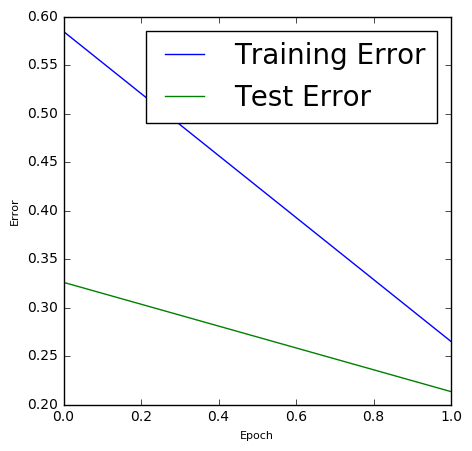

In [9]:
plt.figure(figsize=(5,5))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(test_accs), label='Test Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Error', fontsize=8)
plt.show()

# Histograms

118431
119642
119643
119440
117950
119665


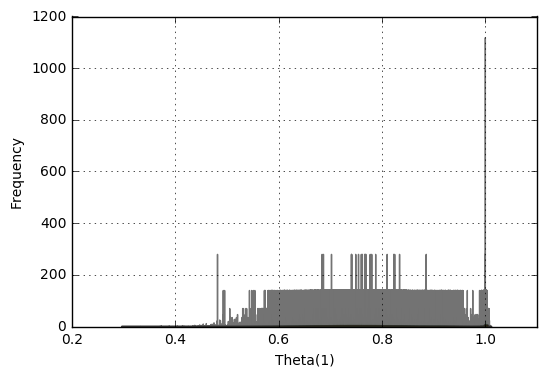

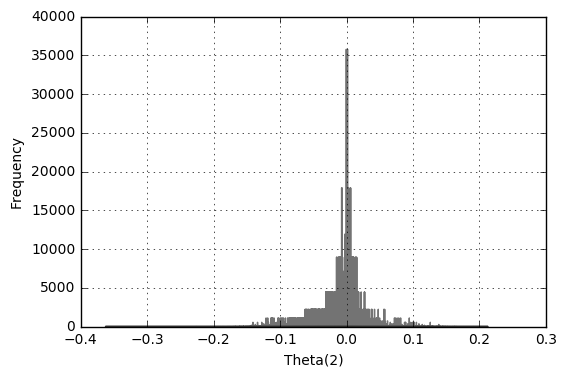

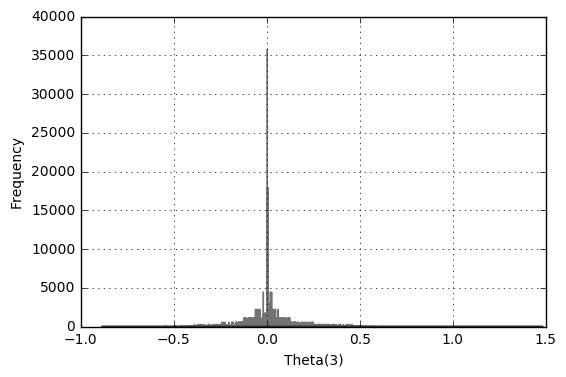

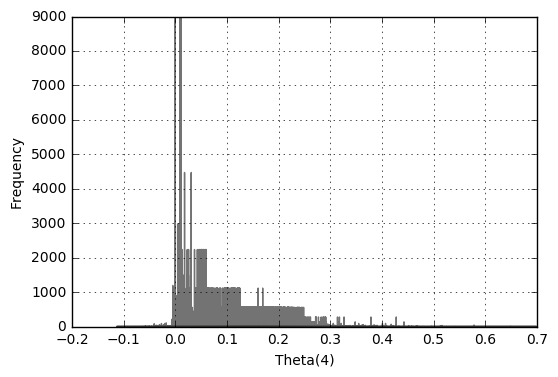

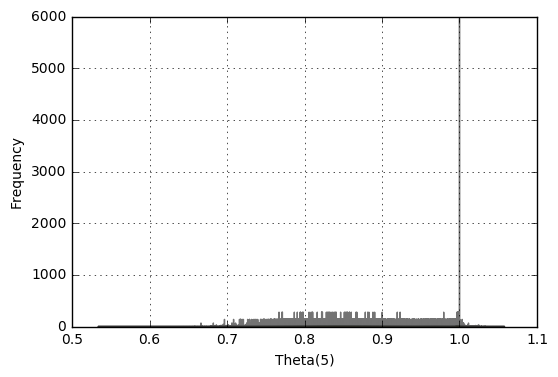

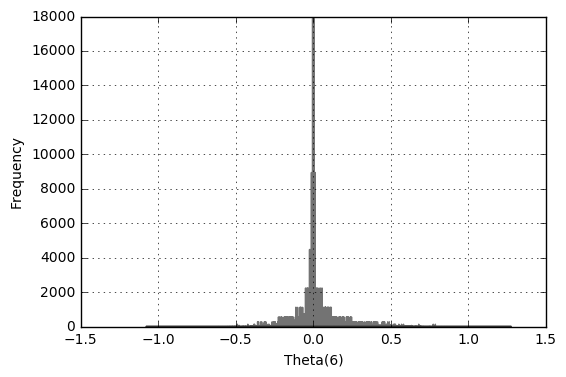

In [10]:
# Histograms
dense_params = param_outputs.reshape((-1, 6))
disc_params = disc_outputs.reshape((-1, 6))

bin_count = 100
plot_over = True

for i in range(0, 6):
    dns = dense_params[:, i]
    
    
    dsc = disc_params[:, i]
    print len(np.unique(dsc))
    #PS: Using normed histograms to plot them over
    # Theta x Dense
    plt.figure()
    n, bins, patches = plt.hist(dns, bins=bin_count, normed=plot_over, histtype='stepfilled')
    plt.setp(patches, 'facecolor', 'r', 'alpha', 0.55)
    if not plot_over:
        plt.xlabel(('Theta({0}) - Discrete Output').format(i+1))
        plt.ylabel('Frequency (Consider bin size)')
        plt.grid(True)
        plt.figure()
    
    # Theta x Discrete
    n, bins, patches = plt.hist(dsc, bins=np.unique(dsc), normed=plot_over, histtype='stepfilled')
    plt.setp(patches, 'facecolor', 'g', 'alpha', 0.55)
    if not plot_over:
        plt.xlabel(('Theta({0}) - Discrete Output').format(i+1))
    else:
        plt.xlabel(('Theta({0})').format(i+1))
    plt.ylabel('Frequency')
    plt.grid(True)


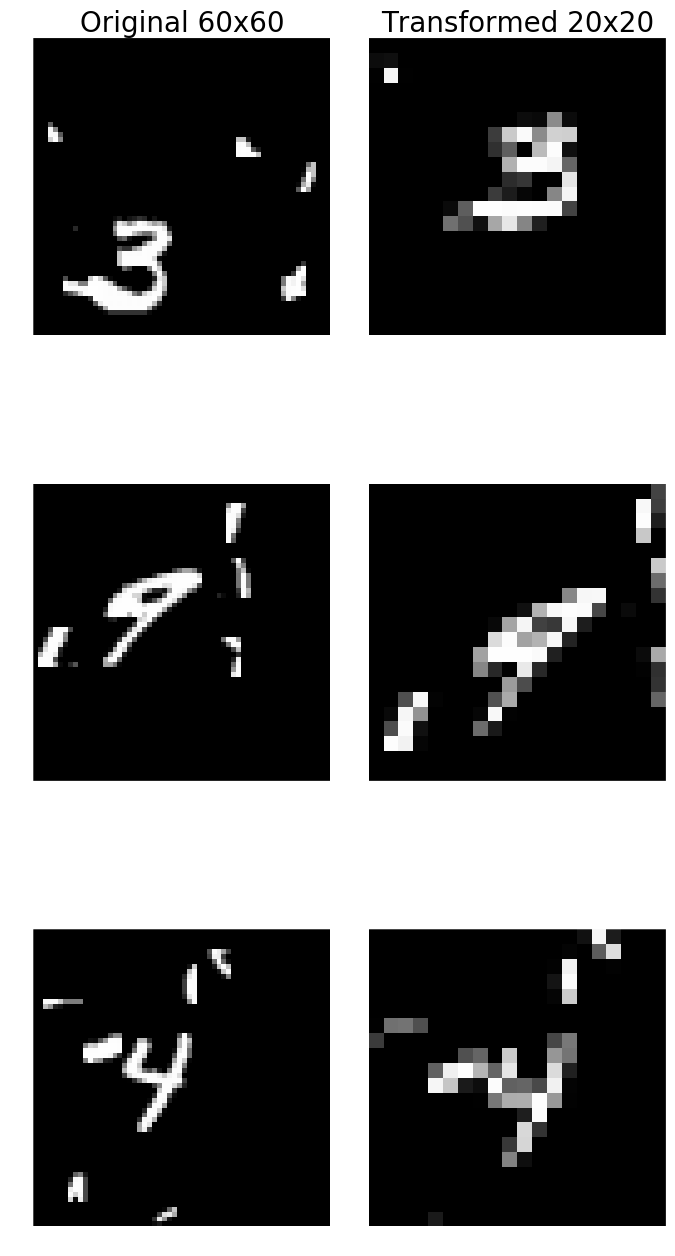

In [11]:
plt.figure(figsize=(7,14))
for i in range(3):
    plt.subplot(321+i*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(322+i*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
plt.tight_layout()
